In [1]:
#    Copyright (C) 2026  DnMdr
#
#    This program is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    (at your option) any later version.
#
#    This program is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#    GNU General Public License for more details.
#
#    You should have received a copy of the GNU General Public License
#    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [2]:
from pathlib import Path

DATA_DIR = Path("data") # Directory dei dati
DATA_DIR.mkdir(parents=True, exist_ok=True) # Crea la cartella dei dati se manca

OUTPUT_DIR = Path("output") # Directory di output
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)   # Crea la cartella di output se manca

FILE_CSV = Path(DATA_DIR, "dati_lanzada.csv")   # Nome del file CSV nella cartella data

COL_DATA = "Data"  # Colonna data e ora
COL_VELOCITA = "Lanzada Frana Fessurimetro F4 - Delta 1h [mm]"  # Cambia F1 con F2, F3, F4
COL_SPOSTAMENTO = "Lanzada Frana Fessurimetro F1 - Dato Grezzo [mm]"  # Cambia F1 con F2, F3, F4
COL_PIOGGIA = "LANZADA Campo Franscia Precipitazione - Dato Grezzo [mm]"    # Dato stazione ARPA Campo Franscia
COL_TEMP = "Lanzada Frana Temperatura roccia TR1 - Dato Grezzo [øC]"    # Dato studio geologico

### Definizione variabili Notebook
##### Parametri
- **inizio_analisi**: Permette di decidere la data di inizio per l'analisi del dataset.
- **v_stazionaria**: Velocità di riferimento (mm/h) per calcolo angolo tangente.
- **soglia_fit_alpha**: Inizia a calcolare la previsione Fukuzono solo sopra questa soglia dell'angolo tangente, i punti utilizzati vengono evidenziati in blu (minimo 80°)
- **coeff_correzione**: Coefficiente statistico di correzione (Qi et al., 2023) compreso tra 0.30 e 0.55 (Il metodo Fukuzono classico corrisponde a C=1)
##### FilteringParams
- **smoothing_technique**: Scegli 1 per Savitsky-Golay o 2 per media mobile
- **finestra_savgol**: Lunghezza della finestra filtro per il metodo savgol (sempre un numero dispari)
- **polinomio_savgol**: Ordine del polinomio utilizzato per il metodo savgol (2 o 3)
- **finestra_media_mobile**: Numero di campioni per la media mobile

In [ ]:
from src.config import Parametri
from src.config import FilteringParams

parametri = Parametri(
    inizio_analisi = "2025-11-10 00:00:00",
    encoding_csv = "latin-1",
    v_stazionaria = 0.02,
    soglia_fit_alpha = 80.0,
    coeff_correzione = 0.50,
    file_csv = FILE_CSV,
    col_data = COL_DATA,
    col_velocita = COL_VELOCITA,
    col_temp = COL_TEMP,
    col_pioggia = COL_PIOGGIA
)

filtering_params = FilteringParams(
    smoothing_technique = 3, # 0 = Nessun filtro, 1 = Savitzky-Golay, 2 = Media Mobile, 3 = Filtro di Kalman
    finestra_savgol = 25,
    polinomio_savgol = 2,
    finestra_media_mobile = 12,
    # Guadagno di Kalman (K)
    kalman_q = 1e-6,    # Varianza del processo (quanto ci fidiamo del modello)
    kalman_r = 1e-4    # Varianza della misura (quanto rumore ha il sensore)
)

In [4]:
# Caricamento e inizializzazione del dataframe
from src.dataframe import dataframe_init
df_main_improved = dataframe_init(parametri)
df_main_improved.tail()

DataFrame troncato all'ultimo dato utile: 2025-11-11 08:15:00


,data,v_clean,temp_C,pioggia_mm,hours_elapsed
383,2025-11-11 07:55:00,0.74,8.7,0.0,31.916667
384,2025-11-11 08:00:00,1.11,8.7,0.0,32.000000
385,2025-11-11 08:05:00,1.64,8.7,0.0,32.083333
386,2025-11-11 08:10:00,2.84,8.7,0.0,32.166667
387,2025-11-11 08:15:00,5.61,8.7,0.0,32.250000


In [5]:
# Funzione di analisi tramite fukuzono e metodo proposto da Qi et al.
from src.fukuzono import fukuzono_qi
risultato = fukuzono_qi(df_main_improved, parametri, filtering_params)

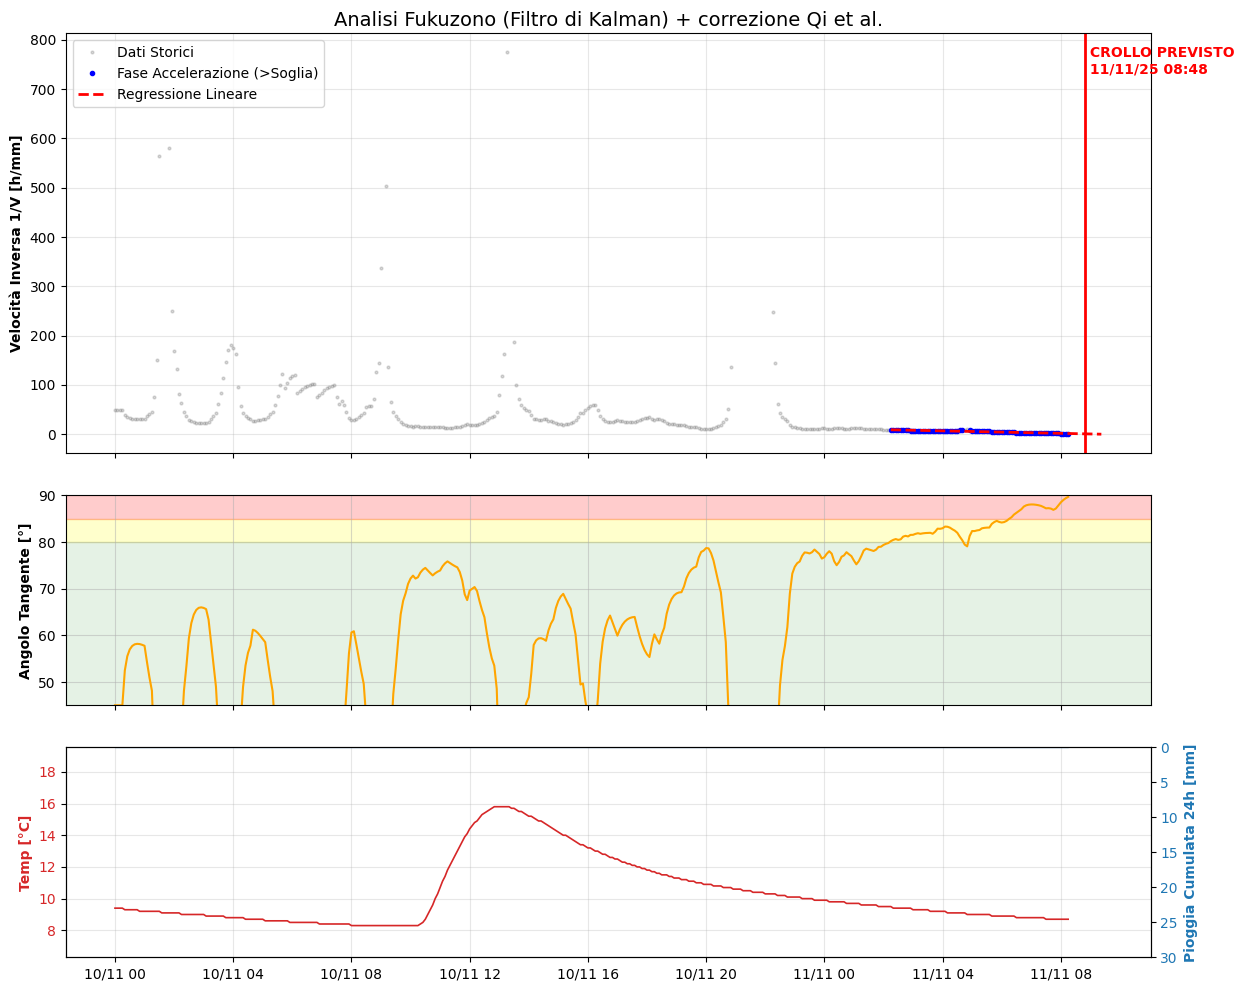

In [6]:
from src.config import GraphicsParams

graphics_params = GraphicsParams(
    filter_name = risultato.smoothing_name,
    figsize = (14, 12),
    col_velocita = COL_VELOCITA,
    col_temp = COL_TEMP,
    col_pioggia = COL_PIOGGIA,
    ylim_emergenza = (45,90)
)

#Funzione di plot
from src.plot import plot_fukuzono
fig = plot_fukuzono(
    df_res=risultato.df_calc, 
    df_main=df_main_improved,
    df_fit=risultato.df_fit, 
    previsione=risultato.previsione, 
    config=graphics_params
)
# Salvataggio del grafico
fig.savefig(Path(OUTPUT_DIR, "grafico_fukuzono.png"), dpi=300, bbox_inches="tight")

In [7]:
# Stampa Report Testuale
from src.report import stampa_report_calibrazione
stampa_report_calibrazione(risultato, parametri)


ANALISI DI CALIBRAZIONE: dati_lanzada.csv
MOMENTO CROLLO REALE (Fine Dati):  11/11/2025 08:15:00
-----------------------------------------------------------------
PREVISIONE FUKUZONO (Lineare):
Data stimata:  11/11/2025 09:22:20
ERRORE (ΔL):   +1h 7m (67 min)

PREVISIONE CORRETTA (Qi et al.):
Coefficiente:  0.5
Data stimata:  11/11/2025 08:48:40
ERRORE (ΔC):   +0h 33m (33 min)
-----------------------------------------------------------------
RISULTATO: Il coefficiente ha ridotto l'errore di 33.7 minuti.

